<a href="https://colab.research.google.com/github/ritwiks9635/Object_Recognition_And_Detection-/blob/main/Face_Detection_Using_RetinaNet_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Human🙎‍♀️Face🙎‍♂️Detection**

[FACE DETECTION DATASET](https://www.kaggle.com/datasets/sbaghbidi/human-faces-object-detection)

In [ ]:
!unzip /content/https:/www.kaggle.com/datasets/sbaghbidi/human-faces-object-detection/human-faces-object-detection.zip

Archive:  /content/https:/www.kaggle.com/datasets/sbaghbidi/human-faces-object-detection/human-faces-object-detection.zip
replace faces.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Install KerasCV and PyCOCOTools metrics
! pip install pycocotools
! pip install git+https://github.com/keras-team/keras-cv@v0.6.4

In [ ]:
import numpy as np
import pandas as pd
import shutil
import zipfile
from sklearn.model_selection import train_test_split


from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt


import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization
from keras.callbacks import LambdaCallback
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as k

In [ ]:
device_name = tf.test.gpu_device_name()

if "GPU" in device_name:
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU not found.')

Found GPU at: /device:GPU:0


In [ ]:
batch_size = 8
n_rows = 2
n_cols = 2
img_size = 160
bbox_format = "xyxy"
auto = tf.data.experimental.AUTOTUNE

##**Preprocess Dataset**

In [ ]:
img_dir = "/content/images"
bbox_path = "/content/faces.csv"
#os.listdir(img_paths)

img_paths = sorted([os.path.join(img_dir, filename) for filename in os.listdir(img_dir)])
print(img_paths[0])

bbox_df = pd.read_csv(bbox_path).sort_values("image_name").reset_index(drop = True)
print(bbox_df.head())


bbox_df = bbox_df[["image_name", "x0", "y0", "x1", "y1"]]

bbox_df = bbox_df.groupby("image_name")

def bbox_generator():
    for _, group in bbox_df:
        bounding_boxes = group[["x0", "y0", "x1", "y1"]].values
        yield bounding_boxes


bbox_dataset = tf.data.Dataset.from_generator(bbox_generator, output_signature = tf.TensorSpec(shape=(None, 4),
               dtype=tf.float32))

/content/images/00000003.jpg
     image_name  width  height    x0   y0    x1    y1
0  00000003.jpg    500     350   101   25   176    87
1  00000004.jpg   1000    1241   476  177   588   335
2  00000005.jpg   1300     957   811  171   976   313
3  00000006.jpg   2667    4000  1002  787  1547  1739
4  00000008.jpg   1300     867   820  234  1016   387


In [ ]:
def preprocess_imags(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    return image



def shuffle_and_split_dataset(dataset, dataset_size, train_ratio = 0.6, valid_ratio = 0.2, test_ratio = 0.2, shuffle = True):
    assert (train_ratio + valid_ratio + test_ratio) == 1

    train_size = int(train_ratio * dataset_size)
    valid_size = int(valid_ratio * dataset_size)
    test_size = int(test_ratio * dataset_size)

    if shuffle:
        dataset = dataset.shuffle(buffer_size = dataset_size, seed = 42)

    train_dataset = dataset.take(train_size)
    valid_dataset = dataset.skip(train_size).take(valid_size)
    test_dataset = dataset.skip(train_size + valid_size).take(test_size)

    return train_dataset, valid_dataset, test_dataset

In [ ]:
def preprocess_bboxes(image, bboxes, bounding_box_format):
    bboxes = bounding_box.convert_format(
        bboxes,
        images = image,
        source = "xyxy",
        target = bounding_box_format)


    # Assuming 'boxes' is a tensor with a known shape
    num_rows = tf.shape(bboxes)[0]

    # Create a new tensor with the same number of rows and all elements set to 14
    new_classes = tf.fill([num_rows], 0)
    new_boxes = tf.cast(bboxes, dtype = tf.float32)

    bounding_boxes = {
        "classes" : new_classes,
        "boxes" : new_boxes
      }
    return {"images" : tf.cast(image, tf.float32), "bounding_boxes" : bounding_boxes}

In [ ]:
img_dataset = tf.data.Dataset.from_tensor_slices(img_paths)
img_dataset = img_dataset.map(preprocess_imags, num_parallel_calls = tf.data.AUTOTUNE)

dataset = tf.data.Dataset.zip((img_dataset, bbox_dataset))

dataset = dataset.map(lambda x, y : preprocess_bboxes(x, y, bbox_format), num_parallel_calls = tf.data.AUTOTUNE)

dataset = dataset.ragged_batch(batch_size)
dataset = dataset.prefetch(buffer_size = auto)

resizing = keras_cv.layers.Resizing(img_size, img_size, pad_to_aspect_ratio = True, bounding_box_format = bbox_format)
dataset = dataset.map(resizing, num_parallel_calls = tf.data.AUTOTUNE)

print(f"Total number of images: {bbox_df.ngroups}")
print(f"Total number of batches for batch size {batch_size}: {bbox_df.ngroups / batch_size}")

num_batches = bbox_df.ngroups // batch_size
print(num_batches)

Total number of images: 2204
Total number of batches for batch size 8: 275.5
275


In [ ]:
train_dataset, valid_dataset, test_dataset = shuffle_and_split_dataset(
      dataset,
      dataset_size = num_batches,
      shuffle = False)


# Add augmentation to training dataset
layers = keras_cv.layers.RandAugment.get_standard_policy(value_range=(0, 255),
                                                    magnitude=.001,
                                                    magnitude_stddev=0.0001,
                                                    geometric=False)
augmenter = keras.Sequential(
    layers = layers + [
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomRotation(factor=0.06, bounding_box_format="xyxy"),
    ]
)

train_dataset = train_dataset.map(augmenter, num_parallel_calls = tf.data.AUTOTUNE)

In [ ]:
data = next(iter(train_dataset.take(1)))

In [ ]:
class_id = ["face"]
class_mapping = dict(zip(range(len(class_id)), class_id))
print(class_mapping)

{0: 'face'}


In [ ]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    print(images.shape)
    print(bounding_boxes["boxes"].shape)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

(8, 160, 160, 3)
(8, None, 4)


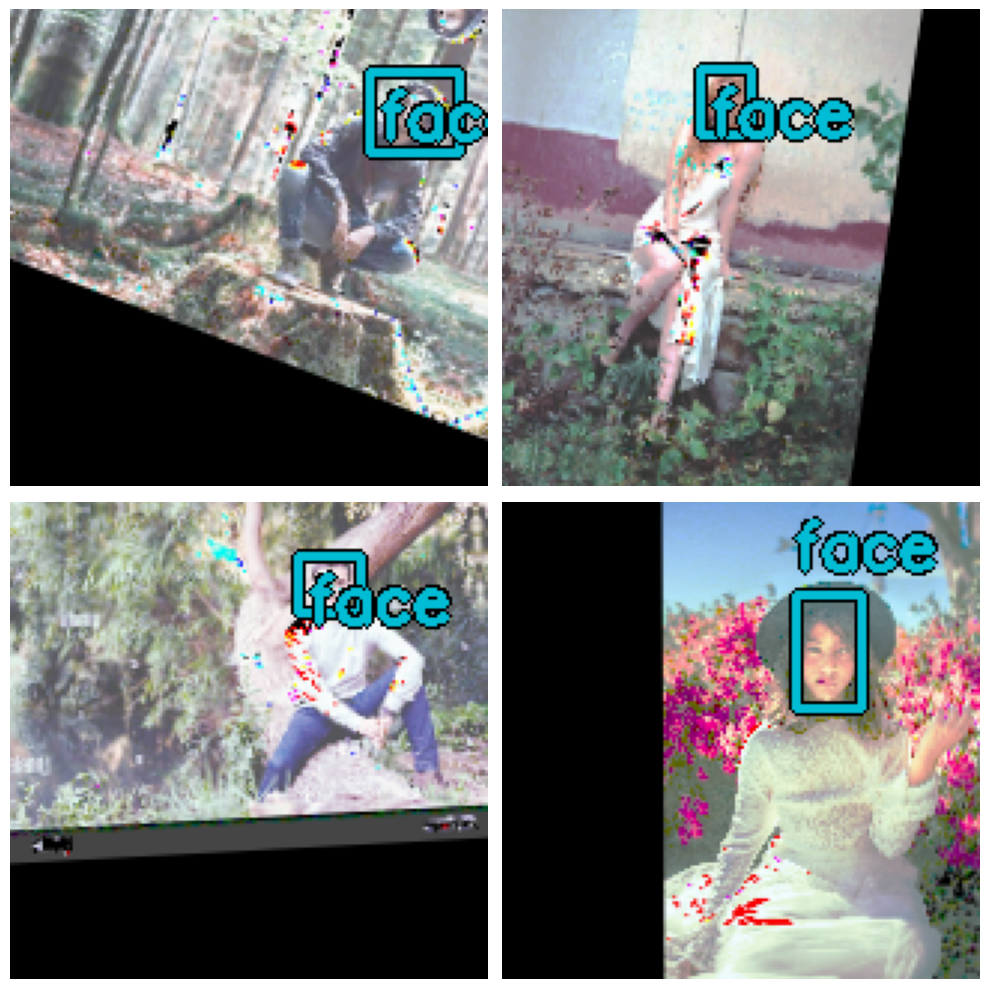

In [ ]:
visualize_dataset(train_dataset,
    value_range = (0, 255),
    rows = n_rows,
    cols = n_cols,
    bounding_box_format = bbox_format)

In [ ]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )

In [ ]:
train_dataset = train_dataset.map(dict_to_tuple, num_parallel_calls = tf.data.AUTOTUNE)
valid_dataset = valid_dataset.map(dict_to_tuple, num_parallel_calls = tf.data.AUTOTUNE)
test_dataset = test_dataset.map(dict_to_tuple, num_parallel_calls = tf.data.AUTOTUNE)

##**Build RetinaNet Model**

In [ ]:
def create_model():
    model = keras_cv.models.RetinaNet.from_preset(
        "resnet50_imagenet",
        num_classes = len(class_mapping),
        bounding_box_format = bbox_format)

    return model

model = create_model()
model.summary()

Model: "retina_net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 images (InputLayer)         [(None, None, None, 3)]      0         []                            
                                                                                                  
 model (Functional)          {'P3': (None, None, None,    2356115   ['images[0][0]']              
                             512),                        2                                       
                              'P4': (None, None, None,                                            
                             1024),                                                               
                              'P5': (None, None, None,                                            
                             2048)}                                                      

In [ ]:
# Customizing non-max supression of model prediction. Necessary to fix bug in NonMaxSuppression
model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format = bbox_format,
    from_logits = True,
    iou_threshold = 0.5,
    confidence_threshold = 0.5,
)

In [ ]:
optimizer = keras.optimizers.Adam(
    learning_rate = 0.001,
    global_clipnorm = 10.0)


coco_metrics = keras_cv.metrics.BoxCOCOMetrics(
    bounding_box_format = bbox_format,
    evaluate_freq = 20)


model.compile(
    optimizer = optimizer,
    classification_loss = "focal",
    box_loss = "smoothl1",
    metrics = [coco_metrics])

##**Callbacks**

In [ ]:
def visualize_detections(model, dataset, bounding_box_format, rows=2, cols=2):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=rows,
        cols=cols,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

In [ ]:
class VisualizeDetections(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch == 5:
            visualize_detections(
                self.model, bounding_box_format = bbox_format, dataset = valid_dataset, rows = n_rows, cols = n_cols
            )


checkpoint_path = "best_model"

early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 5)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor = "val_loss",
        save_best_only = True,
        save_weights_only = True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.1,
    patience = 2,
    min_lr = 1e-6)

lambda_cb = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs:
    print(f"\nEpoch #{epoch+1} \n" +
          f"Loss: {logs['loss']:.4f} \n" +
          f"mAP: {logs['MaP']:.4f} \n" +
          f"Validation Loss: {logs['val_loss']:.4f} \n" +
          f"Validation mAP: {logs['val_MaP']:.4f} \n")
    ),

callbacks = [early_stopping_cb, model_checkpoint, reduce_lr, lambda_cb, VisualizeDetections()]

##**Model Training**

if train model using >= 20 epochs so get better performance..

In [ ]:
model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = 5,
    callbacks = callbacks)

Epoch 1/5
    165/Unknown - 146s 520ms/step - loss: 4.5562 - box_loss: 0.4430 - classification_loss: 4.1132 - MaP: 0.0117 - MaP@[IoU=50]: 0.0411 - MaP@[IoU=75]: 0.0018 - MaP@[area=small]: 0.0017 - MaP@[area=medium]: 0.0187 - MaP@[area=large]: 0.0343 - Recall@[max_detections=1]: 0.0886 - Recall@[max_detections=10]: 0.1547 - Recall@[max_detections=100]: 0.1728 - Recall@[area=small]: 0.0534 - Recall@[area=medium]: 0.2307 - Recall@[area=large]: 0.2070 - percent_boxes_matched_with_anchor: 0.9554
Epoch #1 
Loss: 4.5562 
mAP: 0.0298 
Validation Loss: 4.0320 
Validation mAP: 0.0020 

165/165 [==============================] - 234s 1s/step - loss: 4.5562 - box_loss: 0.4430 - classification_loss: 4.1132 - MaP: 0.0118 - MaP@[IoU=50]: 0.0414 - MaP@[IoU=75]: 0.0018 - MaP@[area=small]: 0.0018 - MaP@[area=medium]: 0.0189 - MaP@[area=large]: 0.0344 - Recall@[max_detections=1]: 0.0892 - Recall@[max_detections=10]: 0.1552 - Recall@[max_detections=100]: 0.1734 - Recall@[area=small]: 0.0536 - Recall@[area

1/1 [==============================] - 2s 2s/step


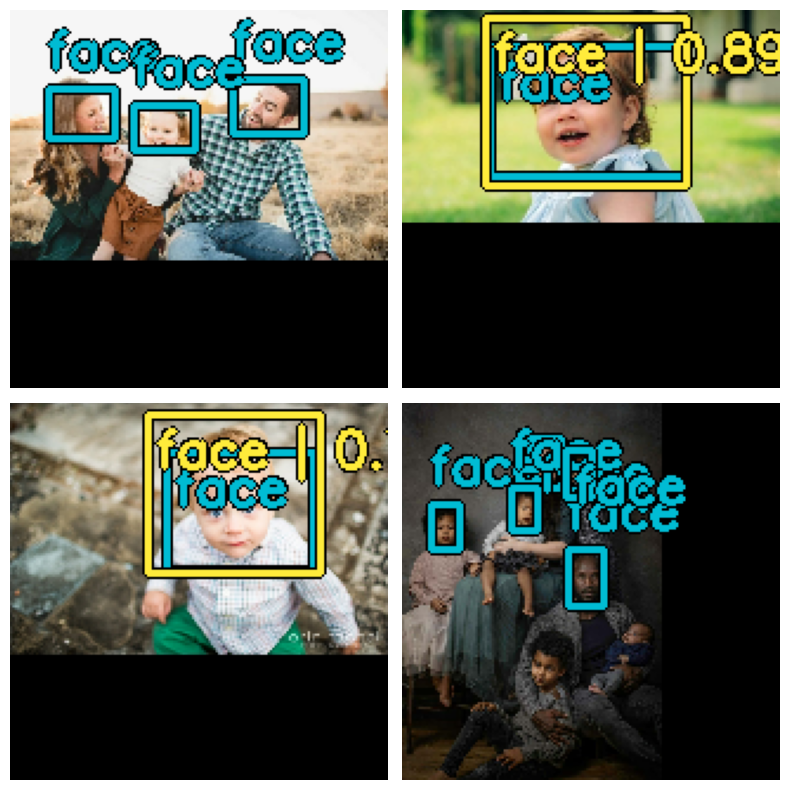

In [ ]:
model.load_weights(checkpoint_path)

# Customizing non-max supression of model prediction. I found these numbers to work fairly well
model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=True,
    iou_threshold=0.1,
    confidence_threshold=0.5,

)
visualize_detections(model, dataset = test_dataset, bounding_box_format = bbox_format, rows = n_rows, cols = n_cols)